In [1]:
from utils import *

import cellxgene_census
from cellxgene_census.experimental.ml import ExperimentDataPipe, experiment_dataloader
import somacore as soma
from somacore import AxisQuery
import torch
from torch.utils.data import DataLoader
torch.ones(2).cuda();

### [Papermill](https://papermill.readthedocs.io/en/latest/) params:

In [31]:
# Set to None to fetch from S3
census_uri = '/mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma'

# Slice 138 total datasets
start = 2
end = 7

n_epochs = 1
BATCH_SIZE = 1024
n_vars = 20_000
SOMA_CHUNK_SIZE = 10_000

# Misc
peek_dataset_lens = None  # When set, initialize loaders and print `len`s for the first [this many] datasets

# Plot configs
period = 10  # Color batch timings by this modulus (to highlight periodic artifacts)
ann_cutoff = .5  # Annotate plot with values for batch timings greater than this threshold
log_plot = False
width = 1200
height = 700

In [3]:
if not census_uri:
    census_uri = None
if census_uri and census_uri.startswith('/'):
    census_loc = 'local'
else:
    census_loc = 'S3'
err(f"Using {census_loc} census")

Using local census


In [4]:
census = cellxgene_census.open_soma(uri=census_uri)

#reference = ln.Collection.filter(uid="1gsdckxvOvIjQgeDVS1F").one().reference
reference = '283d65eb-dd53-496d-adb7-7570c7caa443'
query_collection_id = f"collection_id == '{reference}'"
datasets =(census["census_info"]["datasets"]
           .read(column_names=["dataset_id"], value_filter=query_collection_id)
           .concat().to_pandas())["dataset_id"].tolist()
datasets[:10]

['8e10f1c4-8e98-41e5-b65f-8cd89a887122',
 'b165f033-9dec-468a-9248-802fc6902a74',
 'ff7d15fa-f4b6-4a0e-992e-fd0c9d088ded',
 'fe1a73ab-a203-45fd-84e9-0f7fd19efcbd',
 'fbf173f9-f809-4d84-9b65-ae205d35b523',
 'fa554686-fc07-44dd-b2de-b726d82d26ec',
 'f9034091-2e8f-4ac6-9874-e7b7eb566824',
 'f8dda921-5fb4-4c94-a654-c6fc346bfd6d',
 'f7d003d4-40d5-4de8-858c-a9a8b48fcc67',
 'f6d9f2ad-5ec7-4d53-b7f0-ceb0e7bcd181']

In [5]:
len(datasets)

138

In [6]:
experiment = census["census_data"]["homo_sapiens"]
experiment

<Experiment 'file:///mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens' (open for 'r') (2 items)
    'ms': 'file:///mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens/ms' (unopened)
    'obs': 'file:///mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens/obs' (unopened)>

In [7]:
@dataclass
class Exp:
    datapipe: ExperimentDataPipe
    loader: DataLoader

In [8]:
def get_exp_datapipe(start=None, end=None) -> Exp:
    ds = datasets[slice(start, end)]
    query_datasets = "dataset_id in " + str(ds)
    experiment_datapipe = ExperimentDataPipe(
        experiment,
        measurement_name="RNA",
        X_name="raw",
        obs_query=AxisQuery(value_filter=query_datasets),
        var_query=AxisQuery(coords=(slice(n_vars-1),)),
        batch_size=BATCH_SIZE,
        shuffle=True,
        soma_chunk_size=SOMA_CHUNK_SIZE,
    )
    loader = experiment_dataloader(experiment_datapipe)
    return Exp(experiment_datapipe, loader)

Optional: peek at `peek_dataset_lens` datasets' lengths:

In [9]:
%%time
if peek_dataset_lens:
    exps_prefix = [ get_exp_datapipe(start=i, n=1) for i in range(10) ]
    print([ exp.datapipe.shape[0] for exp in exps_prefix ])

CPU times: user 15 µs, sys: 5 µs, total: 20 µs
Wall time: 38.6 µs


In [11]:
@dataclass
class Batch:
    batch: float
    gc: Optional[float] = None

In [12]:
@dataclass
class Epoch:
    time_per_sample: float
    samples_per_sec: float
    batches: list[Batch]

In [13]:
@dataclass
class Method:
    name: str
    epochs: list[Epoch]

In [14]:
@dataclass
class Results:
    census: Method
    merlin: Optional[Method] = None
    mapped_collection: Optional[Method] = None

In [15]:
def benchmark(exp: Exp) -> Epoch:
    n_samples = exp.datapipe.shape[0]
    loader_iter = exp.loader.__iter__()
    # exclude first batch from benchmark as this includes the setup time
    batch = next(loader_iter)
    
    num_iter = n_samples // BATCH_SIZE if n_samples is not None else None
    
    batches = []
    start_time = batch_time = time()
    
    total = num_iter if num_iter is not None else len(loader_iter)
    for i, batch in tqdm(enumerate(loader_iter), total=total):
        X = batch["x"] if isinstance(batch, dict) else batch[0] 
        # for pytorch DataLoader
        # Merlin sends to cuda by default
        if hasattr(X, "is_cuda") and not X.is_cuda:
            X = X.cuda()
        
        if num_iter is not None and i == num_iter:
            break

        batch_elapsed = time() - batch_time

        gc_time = None
        if i % 10 == 0:
            gc_before = time()
            gc.collect()
            gc_time = time() - gc_before

        batches.append(Batch(batch_elapsed, gc_time))
        batch_time = time()
    
    execution_time = time() - start_time
    gc.collect()
    
    time_per_sample = (1e6 * execution_time) / (total * BATCH_SIZE)
    print(f'time per sample: {time_per_sample:.2f} μs')
    samples_per_sec = total * BATCH_SIZE / execution_time
    print(f'samples per sec: {samples_per_sec:.2f} samples/sec')
    
    return Epoch(samples_per_sec=samples_per_sec, time_per_sample=time_per_sample, batches=batches)

In [16]:
%%time
exp = get_exp_datapipe(start=start, end=end)
exp.datapipe.shape[0]

CPU times: user 7.94 s, sys: 4.14 s, total: 12.1 s
Wall time: 671 ms


133790

## Run benchmark

In [17]:
%%time
epochs = []
for epoch in range(n_epochs):
    epoch = benchmark(exp)
    epochs.append(epoch)

results = Results(
    census=Method('census', epochs),
)

100%|██████████████████| 130/130 [01:12<00:00,  1.79it/s]


time per sample: 544.27 μs
samples per sec: 1837.32 samples/sec
CPU times: user 1min 37s, sys: 50.6 s, total: 2min 27s
Wall time: 1min 16s


In [18]:
results_json_path = f'results-{census_loc}.json'
with open(results_json_path, 'w') as f:
    json.dump(asdict(results), f, indent=2)
    err(f"Saved results to {results_json_path}")

In [19]:
# with open(results_json_path, 'r') as f:
#     results = Results(**json.load(f))

## Plot batch timings

In [20]:
method = 'census'
epoch = 0
batches = getattr(results, 'census').epochs[epoch].batches
df = pd.DataFrame(batches)
df.index.name = 'idx'
if period:
    df['res'] = df.index % period
    df['res_str'] = df.res.astype('str') + f'mod{period}'
df = df.reset_index()
df

,idx,batch,gc,res,res_str
0,0,0.149566,0.448649,0,0mod10
1,1,0.261206,NaN,1,1mod10
2,2,0.248069,NaN,2,2mod10
3,3,0.246372,NaN,3,3mod10
4,4,0.238690,NaN,4,4mod10
...,...,...,...,...,...
125,125,0.109494,NaN,5,5mod10
126,126,0.110607,NaN,6,6mod10
127,127,0.103730,NaN,7,7mod10
128,128,0.109828,NaN,8,8mod10


In [21]:
ann = df[df.batch > ann_cutoff] if ann_cutoff else df[[]]
ann

,idx,batch,gc,res,res_str
8,8,4.738242,NaN,8,8mod10
17,17,1.822496,NaN,7,7mod10
26,26,3.779912,NaN,6,6mod10
36,36,3.579571,NaN,6,6mod10
45,45,1.376704,NaN,5,5mod10
54,54,3.041019,NaN,4,4mod10
64,64,3.031327,NaN,4,4mod10
73,73,2.607092,NaN,3,3mod10
82,82,2.141476,NaN,2,2mod10
92,92,3.029560,NaN,2,2mod10


In [22]:
pc

PlotConfigs(fmt='fig', w=1200, h=800, save=[], v=True, i=None, dir=None, grid='#ccc', bg='white')

Saving: img/census-local.png
Returning IPython Image


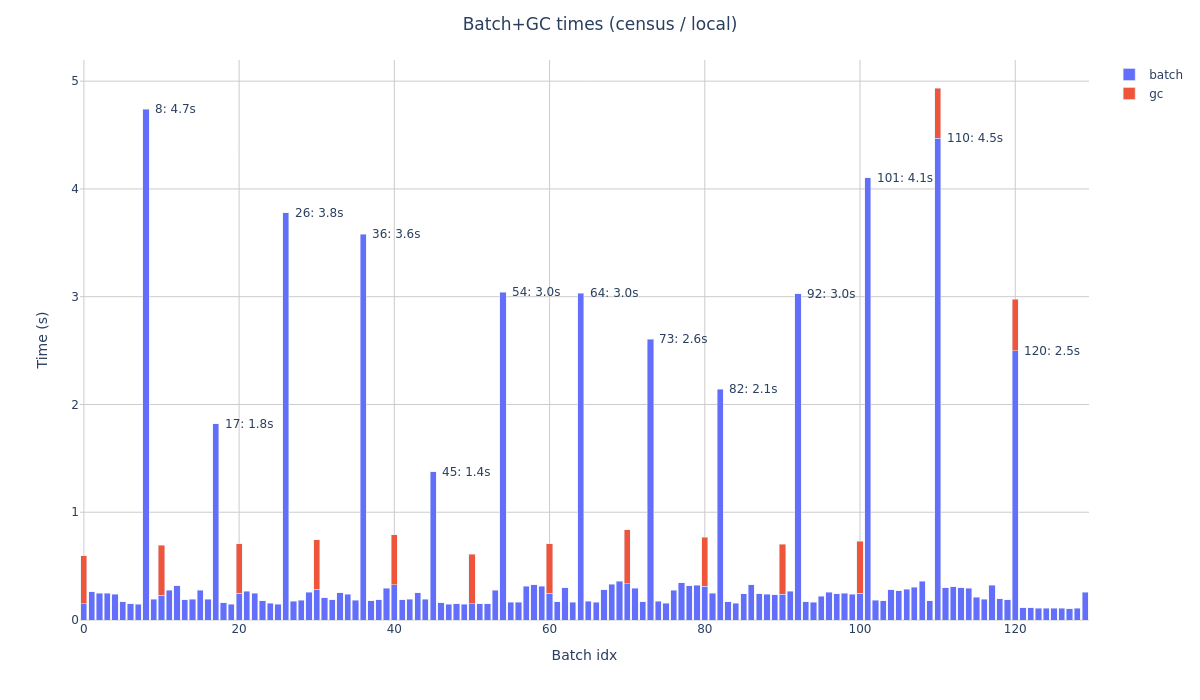

In [33]:
fig = px.bar(
    df.set_index('idx')[['batch', 'gc']],
    barmode='stack',
    labels={
        'idx': 'Batch idx',
        'variable': '',
        'value': 'Time (s)',
    },
    log_y=log_plot,
).update_layout(
    title=dict(text=f'Batch+GC times ({method} / {census_loc})'),
).update_xaxes(
    range=(-.5, len(df) - 1 + .5),
)

if not ann.empty:
    anns = ann.set_index('idx').batch.to_dict().items()
    for idx, batch in anns:
        fig.add_annotation(
            x=idx, y=log10(batch) if log_plot else batch,
            showarrow=False,
            text=f'{idx}: {batch:.1f}s',
            xshift=7,
            xanchor='left',
        )

plot(fig, f'census-{census_loc}', fmt='png', save=['png'], w=width, h=height, dir='img',)